In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# Ergast API base URL
ERGAST_BASE_URL = "http://ergast.com/api/f1"

In [3]:
def fetch_lap_times(year, round_number):
    """Fetch lap times for a specific race."""
    url = f"{ERGAST_BASE_URL}/{year}/{round_number}/laps.json?limit=2000"
    response = requests.get(url)

    # Print debug information
    print(f"Request URL: {url}")
    print(f"Response status code: {response.status_code}")
    print(f"Response content: {response.text[:500]}...")  # Print first 500 characters

    try:
        response.raise_for_status()  # Raise an exception for bad status codes
        data = response.json()
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
        return pd.DataFrame()
    except requests.exceptions.JSONDecodeError as json_err:
        print(f"JSON decode error occurred: {json_err}")
        return pd.DataFrame()
    except Exception as err:
        print(f"An error occurred: {err}")
        return pd.DataFrame()

    try:
        races = data["MRData"]["RaceTable"]["Races"]
        if not races:
            print("No lap time data available for this race.")
            return pd.DataFrame()

        laps = races[0]["Laps"]
    except KeyError:
        print("Expected data structure not found in the API response")
        return pd.DataFrame()

    lap_times = []
    for lap in laps:
        lap_number = int(lap["number"])
        for timing in lap["Timings"]:
            lap_times.append(
                {
                    "lap": lap_number,
                    "driver": timing["driverId"],
                    "time": timing["time"],
                }
            )

    return pd.DataFrame(lap_times)

In [4]:
def time_to_seconds(time_str):
    """Convert lap time string to seconds."""
    parts = time_str.split(":")
    if len(parts) == 2:
        return float(parts[0]) * 60 + float(parts[1])
    return float(parts[0])

In [5]:
def simulate_additional_data(df):
    """Simulate additional data not available from Ergast API."""
    df["tire_compound"] = np.random.choice(["soft", "medium", "hard"], size=len(df))
    df["tire_age"] = np.random.randint(1, 30, size=len(df))
    df["fuel_load"] = 100 - (df["lap"] * 2)  # Assuming 2kg per lap consumption
    df["track_temp"] = np.random.uniform(20, 40, size=len(df))
    df["air_temp"] = np.random.uniform(15, 35, size=len(df))
    df["is_wet"] = np.random.choice([0, 1], size=len(df), p=[0.9, 0.1])

    # Simulate driver skill (1-10 scale)
    unique_drivers = df["driver"].unique()
    driver_skills = {driver: np.random.uniform(7, 10) for driver in unique_drivers}
    df["driver_skill"] = df["driver"].map(driver_skills)

    return df

In [6]:
def prepare_data(year, round_number):
    """Prepare data for model training."""
    df = fetch_lap_times(year, round_number)
    if df.empty:
        return df

    df["lap_time"] = df["time"].apply(time_to_seconds)
    df = simulate_additional_data(df)

    # Feature engineering
    df["tire_age_percentage"] = df["tire_age"] / 30  # Assuming max tire life of 30 laps
    df["fuel_impact"] = df["fuel_load"] * 0.02  # Assuming 0.02s per kg of fuel
    df["track_evolution"] = 1 - (1 / df["lap"])  # Simple track evolution model

    return df

In [7]:
def train_models(X, y):
    """Train multiple regression models."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "SVR": SVR(kernel="rbf"),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = {"model": model, "mse": mse, "mae": mae}

    return results, scaler

In [8]:
def plot_results(results):
    """Plot model performance comparison."""
    names = list(results.keys())
    mse_values = [results[name]["mse"] for name in names]
    mae_values = [results[name]["mae"] for name in names]

    x = range(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, mse_values, width, label="MSE")
    ax.bar([i + width for i in x], mae_values, width, label="MAE")

    ax.set_ylabel("Error")
    ax.set_title("Model Performance Comparison")
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(names)
    ax.legend()

    plt.tight_layout()
    plt.show()

Request URL: http://ergast.com/api/f1/2023/1/laps.json?limit=2000
Response status code: 200
Response content: {"MRData":{"xmlns":"http:\/\/ergast.com\/mrd\/1.5","series":"f1","url":"http://ergast.com/api/f1/2023/1/laps.json","limit":"100","offset":"0","total":"1055","RaceTable":{"season":"2023","round":"1","Races":[{"season":"2023","round":"1","url":"https:\/\/en.wikipedia.org\/wiki\/2023_Bahrain_Grand_Prix","raceName":"Bahrain Grand Prix","Circuit":{"circuitId":"bahrain","url":"http://en.wikipedia.org/wiki/Bahrain_International_Circuit","circuitName":"Bahrain International Circuit","Location":{"lat":"2...
Fetched 100 lap times
Unique drivers: 20
Laps: 1 to 5
   lap          driver      time  lap_time tire_compound  tire_age  fuel_load  \
0    1  max_verstappen  1:39.019    99.019        medium        19         98   
1    1         leclerc  1:40.230   100.230          hard        26         98   
2    1           perez  1:41.063   101.063          soft        13         98   
3    1  

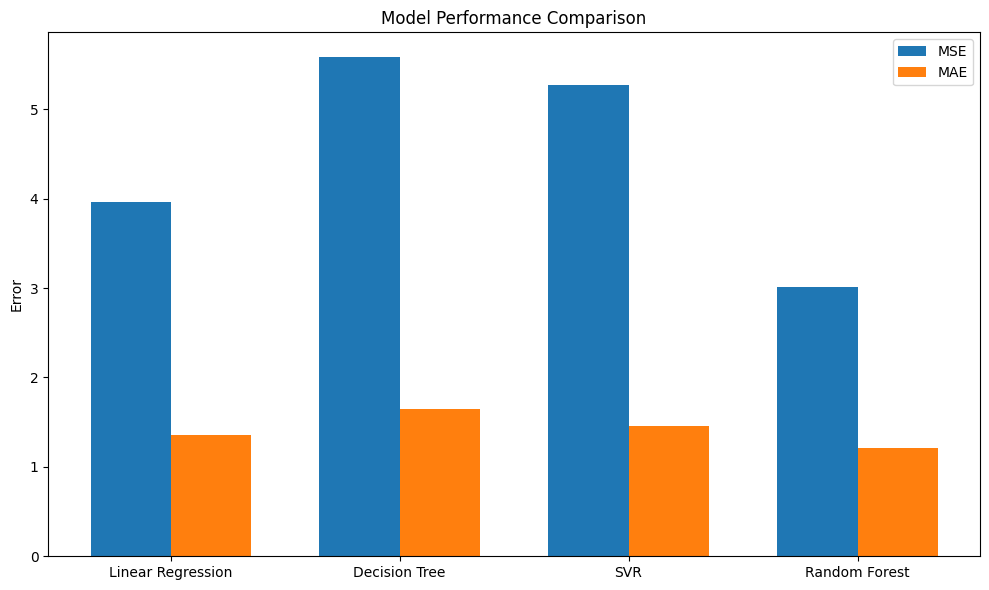

Predicted lap time (Formula 1 format): 01:39.773


c:\Users\vaidy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
def main():
    # Fetch and prepare data
    df = prepare_data(2023, 1)  # 2023 season, first round

    if df.empty:
        print("Failed to fetch lap time data. Exiting.")
        return

    # Print some information about the fetched data
    print(f"Fetched {len(df)} lap times")
    print(f"Unique drivers: {df['driver'].nunique()}")
    print(f"Laps: {df['lap'].min()} to {df['lap'].max()}")
    print(df.head())

    # Prepare features and target
    features = [
        "lap",
        "tire_age",
        "fuel_load",
        "track_temp",
        "air_temp",
        "is_wet",
        "driver_skill",
        "tire_age_percentage",
        "fuel_impact",
        "track_evolution",
    ]
    X = df[features]
    y = df["lap_time"]

    # Train models
    results, scaler = train_models(X, y)

    # Print results
    for name, result in results.items():
        print(f"{name}:")
        print(f"  MSE: {result['mse']:.4f}")
        print(f"  MAE: {result['mae']:.4f}")

    # Plot results
    plot_results(results)

    # Example prediction
    best_model_name = min(results, key=lambda x: results[x]["mse"])
    best_model = results[best_model_name]["model"]

    example_input = np.array(
        [[20, 10, 60, 30, 25, 0, 9, 0.33, 1.2, 0.95]]
    )  # Example feature values
    example_input_scaled = scaler.transform(example_input)
    predicted_lap_time = best_model.predict(example_input_scaled)[0]
    predicted_lap_time = max(0, predicted_lap_time)  # Ensure non-negative lap time

    # Convert predicted lap time to Formula 1 format (MM:SS.sss)
    minutes = int(predicted_lap_time // 60)
    seconds = predicted_lap_time % 60
    milliseconds = (seconds - int(seconds)) * 1000
    f1_format_time = f"{minutes:02}:{int(seconds):02}.{int(milliseconds):03}"

    print(f"Predicted lap time (Formula 1 format): {f1_format_time}")


if __name__ == "__main__":
    main()  

In [10]:
import requests
import pandas as pd


def get_lap_times(year, race_number):
    """Fetches lap times for a specific race from the OpenF1 API.

    Args:
        year (int): The year of the Formula 1 season.
        race_number (int): The race number within the season (1-indexed).

    Returns:
        pandas.DataFrame: DataFrame containing lap times or None if an error occurs.
    """

    url = f"https://ergast.com/api/f1/{year}/{race_number}/laps.json"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()

        # Extract lap time data
        lap_data = []
        for lap in data["MRData"]["RaceTable"]["Races"][0]["Laps"]:
            lap_number = int(lap["number"])
            for timing in lap["Timings"]:
                driver_id = timing["driverId"]
                lap_time = timing["time"]
                lap_data.append([year, race_number, lap_number, driver_id, lap_time])

        df = pd.DataFrame(
            lap_data,
            columns=["year", "race_number", "lap_number", "driver_id", "lap_time"],
        )
        return df
    else:
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        return None


# Example usage
year = 2023
race_number = 1  # For the first race of the season

lap_times_df = get_lap_times(year, race_number)



   year  race_number  lap_number       driver_id  lap_time
0  2023            1           1  max_verstappen  1:39.019
1  2023            1           1         leclerc  1:40.230
2  2023            1           1           perez  1:41.063
3  2023            1           1           sainz  1:41.659
4  2023            1           1        hamilton  1:42.288
